In [3]:
import torch
import random
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('Model', 'PyTorch_CIFAR10'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from cifar10_models.resnet import resnet18

In [4]:
# weight distribution for all layers

import torch
import matplotlib.pyplot as plt

def analyze_model_weights(model, folder_name):
    weights = []
    
    for param in model.parameters():
        if param.requires_grad:  # 학습 가능한 가중치만 선택
            weights.append(param.data.view(-1))  # 1D 텐서로 변환
    
    weights = torch.cat(weights)  # 모든 가중치를 하나의 벡터로 결합
    
    abs_min = torch.min(torch.abs(weights)).item()
    abs_max = torch.max(torch.abs(weights)).item()
    
    # 0보다 큰 값 중 최소값 찾기
    positive_weights = weights[weights > 0]  # 0보다 큰 값 필터링
    min_positive = positive_weights.min().item() if positive_weights.numel() > 0 else None  # 값이 있을 때만 최소값 계산
    
    # 0보다 작은 값 중 최소값 찾기
    negative_weights = weights[weights < 0]  
    min_negative = negative_weights.max().item() if negative_weights.numel() > 0 else None  # 값이 있을 때만 최소값 계산


    print(f"Absolute Min: {abs_min}, Absolute Max: {abs_max:.5f}")
    print(f"Min Positive Value: {min_positive}, Min Negative Value: {min_negative}")
    
    # 가중치 분포 시각화
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1행 2열 서브플롯
    
    # 전체 제목 (중앙)
    fig.suptitle(folder_name, fontsize=16, fontweight='bold')  

    # Linear scale subplot
    axes[0].hist(weights.cpu().numpy(), bins=200, alpha=0.75, color='blue')
    axes[0].set_xlabel("Weight Values")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Weight Distribution (Linear Scale)")
    axes[0].grid(True)

    # Log scale subplot
    axes[1].hist(weights.cpu().numpy(), bins=200, alpha=0.75, color='blue')
    axes[1].set_xlabel("Weight Values")
    axes[1].set_ylabel("Frequency (log scale)")
    axes[1].set_title("Weight Distribution (Log Scale)")
    axes[1].set_yscale('log')  # 로그 스케일 적용
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    return abs_min, abs_max

In [18]:
import numpy as np

# cnn / fc legend
def extract_weights(model):
    conv_weights = []
    fc_weights = []
    for name, param in model.named_parameters():
        if 'weight' in name and len(param.size()) > 1:  # Consider only convolutional and fully connected layers
            if len(param.size()) == 4:  # Convolutional layers
                conv_weights.append(param.data.cpu().numpy().flatten())
            elif len(param.size()) == 2:  # Fully connected layers
                fc_weights.append(param.data.cpu().numpy().flatten())
    return conv_weights, fc_weights


def plot_weights(model, model_name):
    conv_weights, fc_weights = extract_weights(model)
    
     # Flatten the weights list
    all_conv_weights = np.concatenate(conv_weights) if conv_weights else np.array([])
    all_fc_weights = np.concatenate(fc_weights) if fc_weights else np.array([])

    # 0보다 큰 값 중 최소값 찾기
    positive_weights = all_conv_weights[all_conv_weights > 0]  # NumPy 배열에서 필터링
    min_posi = positive_weights.min() if positive_weights.size > 0 else None  # 값이 있을 때만 최소값 계산
    
    # 0보다 작은 값 중 최대값 찾기
    negative_weights = all_conv_weights[all_conv_weights < 0]
    min_nega = negative_weights.max() if negative_weights.size > 0 else None  # 값이 있을 때만 최대값 계산


    print(f"Min Positive Value: {min_posi}, Min Negative Value: {min_nega}")
    
    # Plot the distribution of weights
    plt.hist(all_conv_weights, bins=100, alpha=0.7, label="conv")
    plt.hist(all_fc_weights, bins=100, alpha=0.7, label="fc")
    plt.title(f'{model_name}')
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, axis='y')
    plt.yscale('log')
    plt.show()

def plot_norm_weights(model, model_name):
    conv_weights, fc_weights = extract_weights(model)
    
    # 각 레이어별 min-max 정규화: 각 레이어의 최소값을 -1, 최대값을 1로 매핑
    norm_conv_weights = []
    for layer in conv_weights:
        layer_min = np.min(layer)
        layer_max = np.max(layer)
        if layer_max > layer_min:
            # (x - min) / (max - min) 를 통해 [0, 1]로 변환 후, 2배하고 -1 하면 [-1, 1] 범위가 됨.
            norm_layer = 2 * ((layer - layer_min) / (layer_max - layer_min)) - 1
        else:
            # 만약 layer가 상수값이면 0으로 설정
            norm_layer = np.zeros_like(layer)
        norm_conv_weights.append(norm_layer)
    
    norm_fc_weights = []
    for layer in fc_weights:
        layer_min = np.min(layer)
        layer_max = np.max(layer)
        if layer_max > layer_min:
            norm_layer = 2 * ((layer - layer_min) / (layer_max - layer_min)) - 1
        else:
            norm_layer = np.zeros_like(layer)
        norm_fc_weights.append(norm_layer)
    
    # 정규화된 weight들을 하나의 벡터로 결합
    all_norm_conv_weights = np.concatenate(norm_conv_weights) if norm_conv_weights else np.array([])
    all_norm_fc_weights = np.concatenate(norm_fc_weights) if norm_fc_weights else np.array([])
    
    # 예시: 정규화된 값들에서 0보다 큰 값 중 최소값, 0보다 작은 값 중 최대값도 확인 (conv layer 기준)
    positive_weights = all_norm_conv_weights[all_norm_conv_weights > 0]
    min_posi = positive_weights.min() if positive_weights.size > 0 else None
    
    negative_weights = all_norm_conv_weights[all_norm_conv_weights < 0]
    max_nega = negative_weights.max() if negative_weights.size > 0 else None
    
    print(f"Min Positive (Normalized) Value: {min_posi}, Max Negative (Normalized) Value: {max_nega}")
    
    # 정규화된 weight 분포 시각화 (히스토그램)
    plt.hist(all_norm_conv_weights, bins=100, alpha=0.7, label="Normalized Conv")
    plt.hist(all_norm_fc_weights, bins=100, alpha=0.7, label="Normalized FC")
    plt.title(f'{model_name} (Normalized Weights)')
    plt.xlabel('Normalized Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, axis='y')
    plt.yscale('log')  # 로그 스케일 적용
    plt.show()

Min Positive (Normalized) Value: 1.1920928955078125e-07, Max Negative (Normalized) Value: -2.980232238769531e-07


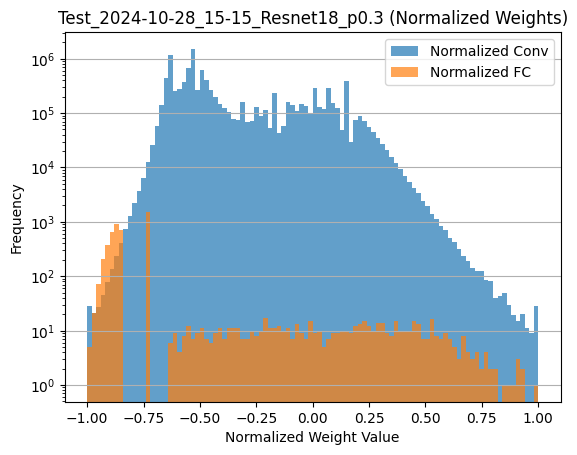

In [19]:
import torch
import matplotlib.pyplot as plt
import sys
import os

folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_norm_weights(model, folder_name)

In [20]:
conv_weights, fc_weights = extract_weights(model)

In [21]:
conv_weights

[array([ 0.02321908,  0.05806632,  0.03181854, ..., -0.00739009,
         0.00725325,  0.        ], dtype=float32),
 array([ 0.00628015,  0.00514479, -0.00117541, ...,  0.00306997,
         0.00651648,  0.00350876], dtype=float32),
 array([ 0.00287212,  0.        ,  0.        , ..., -0.00799529,
         0.        , -0.        ], dtype=float32),
 array([ 0.00735277,  0.00426802,  0.00229479, ..., -0.00357516,
         0.00359326, -0.        ], dtype=float32),
 array([ 0.00634524,  0.00966469, -0.        , ..., -0.0072438 ,
        -0.00614158,  0.00755578], dtype=float32),
 array([ 0.00440122,  0.0070317 ,  0.        , ...,  0.00312522,
        -0.00239964, -0.        ], dtype=float32),
 array([-0.01023024,  0.        , -0.00223521, ..., -0.00295239,
         0.00257678,  0.00269075], dtype=float32),
 array([ 0.02209109, -0.01284246, -0.        , ...,  0.01709459,
        -0.02380284,  0.        ], dtype=float32),
 array([ 0.00916918, -0.00281484, -0.00799076, ...,  0.00460099,
       

Min Positive Value: 4.362919935374521e-05, Min Negative Value: -4.362919935374521e-05


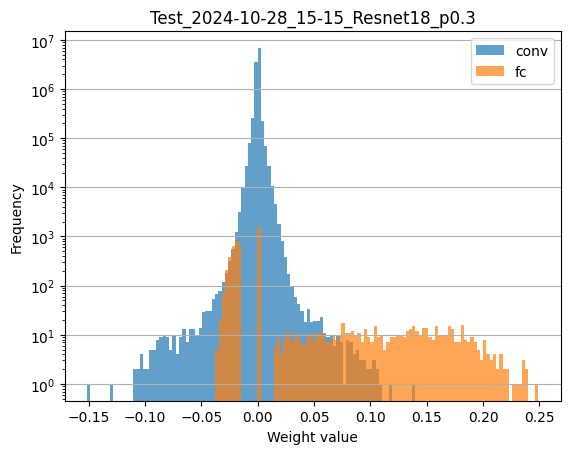

In [11]:
import torch
import matplotlib.pyplot as plt
import sys
import os

folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_weights(model, folder_name)

Min Positive Value: 6.0688937082886696e-05, Min Negative Value: -6.0688998928526416e-05


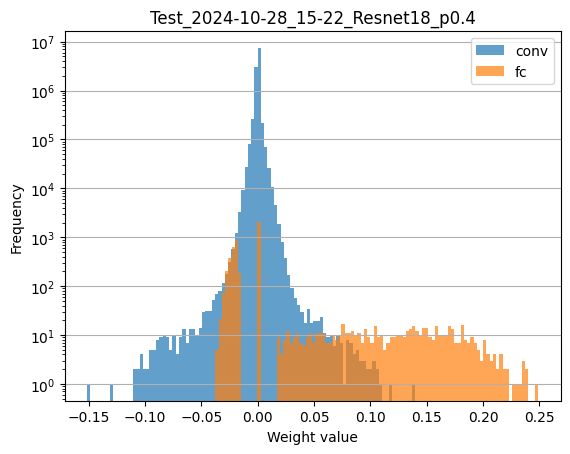

In [12]:
folder_name = 'Test_2024-10-28_15-22_Resnet18_p0.4'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_weights(model, folder_name) 

Min Positive Value: 8.043241541599855e-05, Min Negative Value: -8.043296838877723e-05


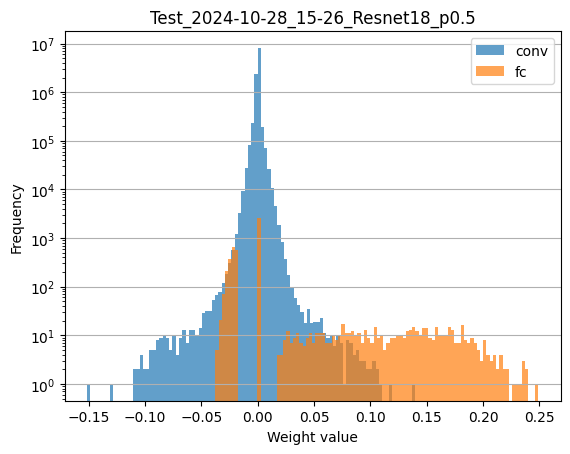

In [13]:
folder_name = 'Test_2024-10-28_15-26_Resnet18_p0.5'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_weights(model, folder_name) 

Min Positive Value: 0.0001375446154270321, Min Negative Value: -0.00013754489191342145


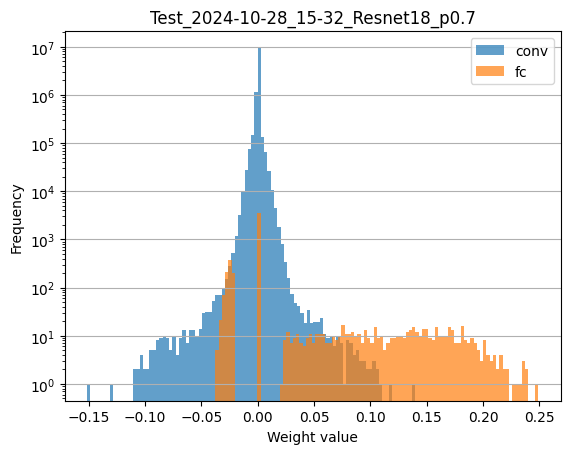

In [15]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
plot_weights(model, folder_name) 

Absolute Min: 0.0, Absolute Max: 0.24882
Min Positive Value: 2.8966287572984584e-06, Min Negative Value: -2.0657858840422705e-05


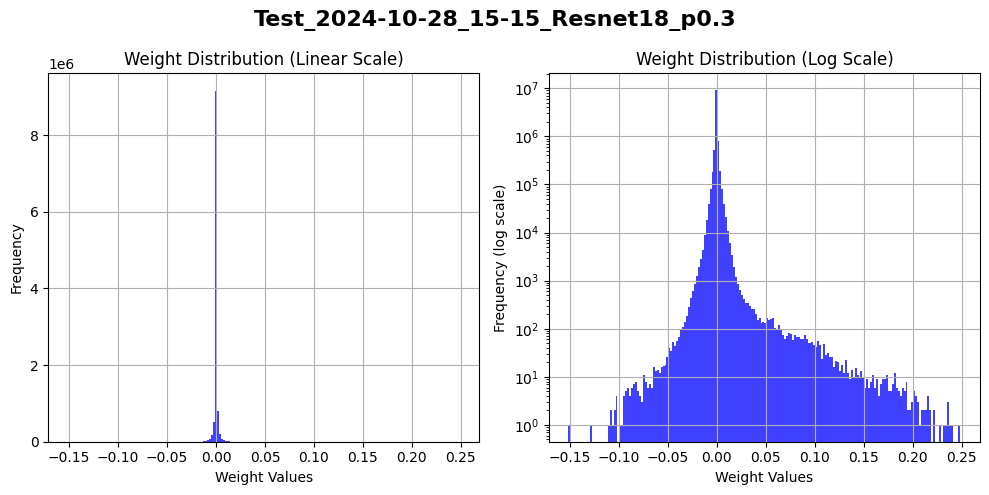

(0.0, 0.2488204836845398)

In [5]:
import torch
import matplotlib.pyplot as plt
import sys
import os

folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
analyze_model_weights(model, folder_name)

Absolute Min: 0.0, Absolute Max: 0.24882
Min Positive Value: 2.8966287572984584e-06, Min Negative Value: -2.0657858840422705e-05


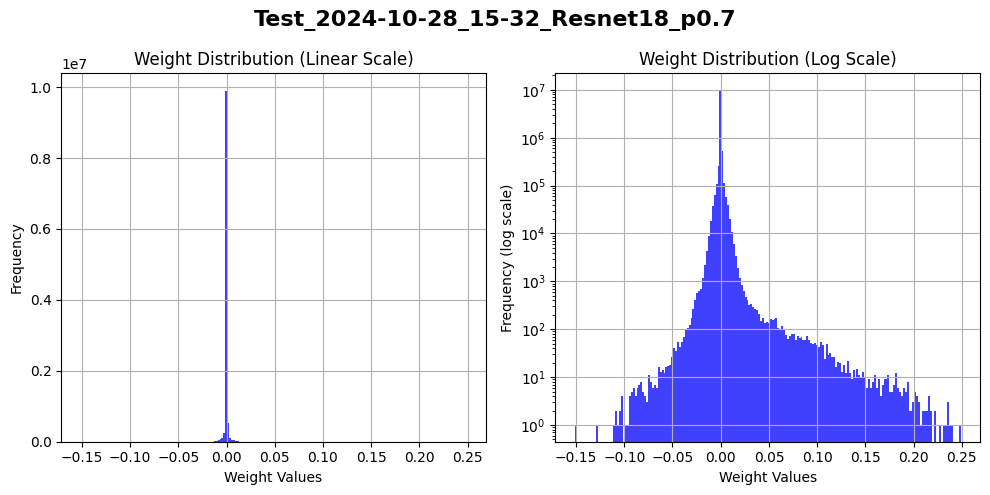

(0.0, 0.2488204836845398)

In [30]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
analyze_model_weights(model, folder_name)